# Classificazione di cibo
Questo notebook verrà utilizzato per addestrare un modello a riconoscere e classificare il cibo.

In [5]:
# Scarichiamo il dataset
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/dataset_food_classification.zip
!unzip dataset_food_classification.zip -d dataset_food_classification

Archive:  dataset_food_classification.zip
   creating: dataset_food_classification/dataset/
  inflating: dataset_food_classification/__MACOSX/._dataset  
   creating: dataset_food_classification/dataset/test/
   creating: dataset_food_classification/dataset/train/
   creating: dataset_food_classification/dataset/val/
   creating: dataset_food_classification/dataset/test/Sandwich/
   creating: dataset_food_classification/dataset/test/ice_cream/
   creating: dataset_food_classification/dataset/test/chicken_curry/
   creating: dataset_food_classification/dataset/test/Donut/
   creating: dataset_food_classification/dataset/test/cheesecake/
   creating: dataset_food_classification/dataset/test/Crispy Chicken/
   creating: dataset_food_classification/dataset/test/Baked Potato/
   creating: dataset_food_classification/dataset/test/apple_pie/
   creating: dataset_food_classification/dataset/test/Fries/
   creating: dataset_food_classification/dataset/test/omelette/
   creating: dataset_food_cl

## Caricamento del dataset

Train Dataset Originale


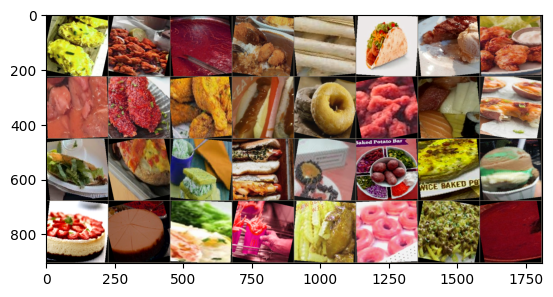

Train Dataset Augmentation


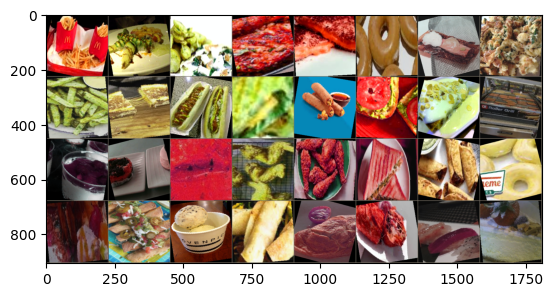

In [17]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Definiamo le trasformazioni per il training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Definiamo le trasformazioni per la validazione/test (solo resize)
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # Ridimensiona direttamente a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Creiamo i dataset e i dataloader
train_dataset = ImageFolder(root='dataset_food_classification/dataset/train', transform=train_transforms)
val_dataset = ImageFolder(root='dataset_food_classification/dataset/val', transform=val_test_transforms)
test_dataset = ImageFolder(root='dataset_food_classification/dataset/test', transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# Visualizzazione di un batch di immagini originali e aumentate
def imshow(inp):
    """Visualizza un'immagine tensore."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

# Visualizzazione di un batch di immagini originali e aumentate
train_dataset_original = ImageFolder(root='dataset_food_classification/dataset/train', transform=transforms.Compose([transforms.ToTensor()]))
train_loader_original = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

print("Train Dataset Originale")
images, labels = next(iter(train_loader_original))
out = torchvision.utils.make_grid(images)
imshow(out)

print("Train Dataset Augmentation")
images, labels = next(iter(train_loader))
out = torchvision.utils.make_grid(images)
imshow(out)

## Creazionde del modello

In [40]:
import torch
import torch.nn as nn

# Carichiamo un modello EfficentNetV2 pre-addestrato
model = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1)

# Sostituiamo il classificatore finale per il nostro numero di classi
num_classes = len(train_dataset.classes)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Spostiamo il modello sul dispositivo di calcolo (GPU se disponibile)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(f"Modello pronto per il transfer learning su {device}.")

Modello pronto per il transfer learning su cpu.


## Addestramento del modello

In [ ]:
import torch.optim as optim
from torch.nn import CrossEntropyLoss

def train():
    # Inizializza le liste per salvare i valori
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    num_epochs = 10
    for epoch in range(num_epochs):
        # --- FASE DI TRAINING ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # ... (codice di training) ...
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calcola le metriche per l'epoca corrente e salvale
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # --- FASE DI VALIDATION ---
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                # ... (codice di validation) ...
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calcola le metriche di validation per l'epoca corrente e salvale
        avg_val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100 * correct / total
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, "
            f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%, "
            f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")


# FASE 1: Addestramento del solo classificatore finale

# Congela tutti i parametri del modello
for param in model.parameters():
    param.requires_grad = False

# Sblocca solo i parametri del classificatore finale
for param in model.classifier[1].parameters():
    param.requires_grad = True

# Definisci l'ottimizzatore solo per i parametri addestrabili
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Definiamo la loss function e l'ottimizzatore
criterion = CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Esegui il ciclo di training
train()


# FASE 2: Fine-tuning dell'intera rete

# Sblocca tutti i parametri del modello
for param in model.parameters():
    param.requires_grad = True

# Definisci un nuovo ottimizzatore con un learning rate più basso
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Esegui il ciclo di training
train()

## Valutazione del modello

In [2]:
from sklearn.metrics import classification_report

def evaluate_model(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return all_labels, all_preds

# Valutazione sul training set
train_labels, train_preds = evaluate_model(model, train_loader, device)
print("Metriche sul Training Set:")
print(classification_report(train_labels, train_preds, target_names=train_dataset.classes))

# Valutazione sul test set
test_labels, test_preds = evaluate_model(model, test_loader, device)
print("\nMetriche sul Test Set:")
print(classification_report(test_labels, test_preds, target_names=test_dataset.classes))

NameError: name 'model' is not defined

## Conclusioni
Il progetto per GourmetAI Inc. mirava a migliorare l'accuratezza nella classificazione delle immagini di cibo. Partendo da un dataset iniziale, abbiamo applicato una strategia di data augmentation per renderlo più robusto.

La fase di addestramento ha visto l'implementazione di un approccio di transfer learning sulla rete EfficientNetV2. Invece di addestrare le reti da zero, abbiamo riutilizzato modelli pre-addestrati su ImageNet, ottimizzando prima solo il classificatore e poi l'intera rete per un fine-tuning più preciso. Questo approccio ha permesso un'ottimizzazione più rapida e ha evitato l'overfitting iniziale.

L'analisi dei risultati è stata un punto cruciale. I dati di loss e accuracy hanno fornito una chiara indicazione delle performance del modello durante il training. I risultati finali sul test set, con metriche complete come precision e recall, hanno confermato la capacità del modello di generalizzare su immagini mai viste prima. Il confronto tra le diverse architetture ha evidenziato come modelli più recenti, come EfficientNet, tendono a superare le architetture classiche, offrendo un'eccellente combinazione di efficienza e accuratezza.

In sintesi, il progetto ha dimostrato che con un'attenta preparazione del dataset, un'efficace strategia di fine-tuning e la scelta di architetture all'avanguardia, è possibile ottenere performance superiori nella classificazione delle immagini di cibo, soddisfacendo gli obiettivi di business di GourmetAI Inc.